In [8]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('..')
import dvu
import seaborn as sns
import os
import pandas as pd
from copy import deepcopy
from matplotlib import pyplot as plt
from os.path import join
import numpy as np
import imodelsx.process_results
import qa_questions
import joblib
from tqdm import tqdm
fit_encoding = __import__('01_fit_encoding')
dvu.set_style()

# results_dir = '/home/chansingh/mntv1/deep-fMRI/encoding/results_mar27'
results_dir = '/home/chansingh/mntv1/deep-fMRI/encoding/results_mar28'
experiment_filename = '../experiments/01_fit_encoding.py'

# load the results in to a pandas dataframe
r = imodelsx.process_results.get_results_df(results_dir)
r = imodelsx.process_results.fill_missing_args_with_default(
    r, experiment_filename)
cols_varied = imodelsx.process_results.get_experiment_keys(
    r, experiment_filename)
print('experiment varied these params:', cols_varied)

mets = [c for c in r.columns if 'corrs_test_' in c] + \
    [c for c in r.columns if 'corrs_tune_' in c]
mets = [met for met in mets if not 'pc' in met]
if len(cols_varied) > 0:
    d = r.groupby(cols_varied)[mets].mean()
else:
    d = r[mets]
(
    d
    .sort_values(by='corrs_test_mean', ascending=False)
    .rename(columns=lambda x: x.replace('_', ' ').replace('corrs', ''))
    .style
    .background_gradient(cmap='magma', axis=0)
    .format(precision=3)
)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


100%|██████████| 34/34 [00:00<00:00, 360.67it/s]


experiment varied these params: ['feature_space', 'pc_components', 'ndelays', 'nboots']


# Compare performance of a few different models

In [4]:
qa = r[(r.feature_space == 'qa_embedder-5')
       ].sort_values(by='corrs_tune_mean', ascending=False).iloc[0]
eng1000 = r[(r.feature_space == 'eng1000')].sort_values(
    by='corrs_tune_mean', ascending=False).iloc[0]

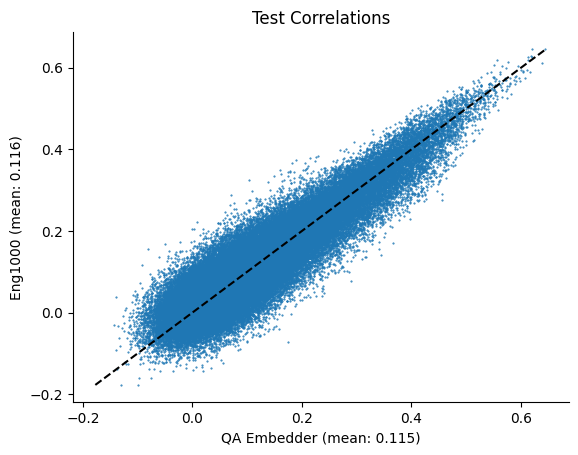

In [7]:
plt.plot(qa['corrs_test'], eng1000['corrs_test'], '.', ms=1)
plt.xlabel(f'QA Embedder (mean: {qa["corrs_test"].mean():0.3f})')
plt.ylabel(f'Eng1000 (mean: {eng1000["corrs_test"].mean():0.3f})')
plt.title('Test Correlations')
m_max = max(qa['corrs_test'].max(), eng1000['corrs_test'].max())
m_min = min(qa['corrs_test'].min(), eng1000['corrs_test'].min())
plt.plot([m_min, m_max], [m_min, m_max], 'k--')
plt.show()

### Check parameters for rerunning expts (alphas, delays)

In [10]:
# args = r[(r.pc_components == -1) * (r.ndelays == 8)].iloc[0]
# args = r.sort_values(by='corrs_test_mean').iloc[-1]
args = qa
model_params_to_save = joblib.load(
    join(args.save_dir_unique, 'model_params.pkl'))
print(args.feature_space)

qa_embedder-5


In [11]:
pd.Series(model_params_to_save['alphas_best']).value_counts()

432.876128     60
231.012970     25
811.130831     12
1519.911083     3
Name: count, dtype: int64

In [25]:
ndelays = args.ndelays
weights = model_params_to_save['weights']
assert weights.shape[0] % ndelays == 0
emb_size = weights.shape[0] / ndelays

# chunk weights by emb_size and make violion plots
weights = weights.reshape(ndelays, int(emb_size), -1)

# # Look at mean abs coefs
# weights = np.abs(weights.reshape(ndelays, -1))
# print('means (first value is delay=1, then delay=2, ...)',
#       weights.mean(axis=1), np.median(weights, axis=1))
# plt.plot(np.arange(ndelays) + 1, weights.mean(axis=1))
# plt.xlabel('Delays')
# plt.ylabel('Mean abs coef')
# plt.show()

# look at coefs per feature
weights = np.swapaxes(weights, 0, 1)  # emb_size, ndelays, nfeatures
weights = weights.reshape(int(emb_size), -1)
weights = np.abs(weights)
weights_per_feat = weights.mean(axis=-1)

In [29]:
questions = qa_questions.get_questions()

In [54]:
df = (
    pd.DataFrame({
        'question': questions,
        'avg_abs_coef_normalized': weights_per_feat / weights_per_feat.max()
    }).sort_values(by='avg_abs_coef_normalized', ascending=False)
    .set_index('question')
    .round(3)
)
# df.to_json('../questions_v1.json', orient='index', indent=2)
df.to_csv('../questions_v1.csv')

In [46]:
df.set_index('question')

,avg_abs_weight_normalized
question,
Does the sentence contain a question?,1.000000
Does the sentence include dialogue?,0.976667
Does the input include a philosophical or reflective thought?,0.943918
Does the sentence describe a physical sensation?,0.939081
Does the input describe a sensory experience?,0.915804
...,...
Does the story talk about a personal challenge?,0.130353
Does the story include an act of bravery or courage?,0.128270
Is there a discussion of a psychological concept or mental health issue?,0.127892


### Hybrid models

In [ ]:
args = r[(r.pc_components == -1) * (r.feature_space == 'qa_embedder-5')
         ].sort_values(by='corrs_tune_mean', ascending=False).iloc[0]
args2 = r[(r.pc_components > 0) * (r.feature_space == 'qa_embedder-5')
          ].sort_values(by='corrs_tune_mean', ascending=False).iloc[0]
# args = r[]

# args2 = r[(r.feature_space == 'eng1000')].iloc[0]
# args = r[(r.pc_components == -1) * (r.feature_space == 8)].iloc[0]
# args = r[(r.pc_components == -1) * (r.ndelays == 8)].iloc[0]
# model_params_to_save = joblib.load(
# join(args.save_dir_unique, 'model_params.pkl'))

In [ ]:
percentile_thresholds = np.arange(0, 100, 1)
corrs_tune_individual = args['corrs_tune']
corrs_test_individual = args['corrs_test']
corrs_test_pca = args2['corrs_test']
res = []
for percentile_threshold in percentile_thresholds:
    args_top_thresh = np.where(corrs_tune_individual > np.percentile(
        corrs_tune_individual, percentile_threshold))[0]
    args_non_top_thresh = np.where(corrs_tune_individual <= np.percentile(
        corrs_tune_individual, percentile_threshold))[0]
    args_total = np.concatenate([args_top_thresh, args_non_top_thresh])
    mean_corr_weighted = (corrs_test_individual[args_top_thresh].mean() * args_top_thresh.size +
                          corrs_test_pca[args_non_top_thresh].mean() * args_non_top_thresh.size) / args_total.size
    # print('mean corr weighted',
    #       (corrs_test_individual[args_top_thresh].mean() * args_top_thresh.size +
    #        corrs_test_pca[args_non_top_thresh].mean() * args_non_top_thresh.size) / args_total.size
    #       )
    res.append(mean_corr_weighted)
plt.plot(percentile_thresholds, res)
plt.axhline(corrs_test_individual.mean(), color='k', linestyle='--')
plt.axhline(corrs_test_pca.mean(), color='r', linestyle='--')
plt.show()

### Validate model weights usage

In [ ]:
story_names_train, story_names_test = fit_encoding.get_story_names(args)
stim_test_delayed, resp_test = fit_encoding.get_data(args, story_names_test)

In [ ]:
def _calc_corrs(preds, resp):
    corrs = []
    for i in tqdm(range(preds.shape[1])):
        corrs.append(np.corrcoef(
            preds[:, i], resp[:, i])[0, 1])
    return np.array(corrs)

In [ ]:
wt = model_params_to_save['weights']
preds_test = stim_test_delayed @ wt
corrs_test = _calc_corrs(preds_test, resp_test)
print(np.mean(corrs_test))
print(args.corrs_test_mean)
assert np.allclose(corrs_test, args['corrs_test'])

### Evaluate PC models

In [ ]:
args = r[(r.pc_components == 100) * (r.feature_space == 'qa_embedder-5')
         ].sort_values(by='corrs_tune_mean', ascending=False).iloc[0]

In [ ]:
story_names_train, story_names_test = fit_encoding.get_story_names(args)
stim_test_delayed, resp_test = fit_encoding.get_data(args, story_names_test)

In [ ]:
model_params_to_save = joblib.load(
    join(args.save_dir_unique, 'model_params.pkl'))

In [ ]:
wt = model_params_to_save['weights']
# + model_params_to_save['bias'] (not needed for just calculating corr, but needed for predictions)
preds_test = stim_test_delayed @ wt

corrs_test = _calc_corrs(preds_test, resp_test)
print(np.mean(corrs_test))
print(args.corrs_test_mean)
assert np.allclose(corrs_test, args['corrs_test'])

Original setup, before we had unpacked weights

In [ ]:
wt_pc = model_params_to_save['weights_pc']
pca = model_params_to_save['pca']
scaler_test = model_params_to_save['scaler_test']
preds_pc = stim_test_delayed @ wt_pc
preds_pc_scaled = scaler_test.inverse_transform(preds_pc)
preds_voxels = pca.inverse_transform(preds_pc_scaled)
corrs_test = _calc_corrs(preds_voxels, resp_test)
assert np.allclose(corrs_test, args['corrs_test'])

In [ ]:
# Vary number of pcs included
num_pcs = [5, 25, 50, 100, 200, 500, 1000]
corrs = []
for num_pc in num_pcs:
    wt_pc = model_params_to_save['weights_pc']
    pca = model_params_to_save['pca']
    scaler_test = model_params_to_save['scaler_test']
    preds_pc = stim_test_delayed @ wt_pc
    preds_pc_scaled = scaler_test.inverse_transform(preds_pc)

    pca_subset = deepcopy(pca)
    pca_subset.components_[num_pc:] = 0
    preds_voxels = pca_subset.inverse_transform(preds_pc_scaled)

    corrs_test = _calc_corrs(preds_voxels, resp_test)
    # assert np.allclose(corrs_test, args['corrs_test'])
    print(num_pc, np.mean(corrs_test))
    corrs.append(np.mean(corrs_test))
plt.plot(num_pcs, corrs)

In [ ]:
corrs_test = fit_encoding.evaluate_pc_model_on_each_voxel(
    args, stim_test_delayed, resp_test,
    model_params_to_save, pca, scaler_test)

In [ ]:
wt = model_params_to_save['weights']

# multiply
preds_pc = stim_test_delayed @ wt
preds_pc_unscaled = preds_pc * scaler_test.scale_ + scaler_test.mean_
preds_voxels2 = preds_pc_unscaled @ pca.components_ + pca.mean_

# rewrite the above as a multiplication of a single weight matrix
preds_voxels2 = (stim_test_delayed @ wt * scaler_test.scale_ +
                 scaler_test.mean_) @ pca.components_ + pca.mean_
weight_full = wt * scaler_test.scale_ @ pca.components_
bias_full = scaler_test.mean_ @ pca.components_ + pca.mean_
preds_voxels2 = stim_test_delayed @ weight_full + bias_full

assert np.allclose(preds_voxels, preds_voxels2)

In [ ]:
assert corrs_test.mean() == args.corrs_test_mean